<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DEPENDENCIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import ResNet50V2
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
#HYPERPARAMETER

EPOCHS = 3
LOSS = CategoricalCrossentropy()
OPTIMIZERS = Adam()
input_shape = (224,224,3)

Labeling Photo Using ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Show All Classes

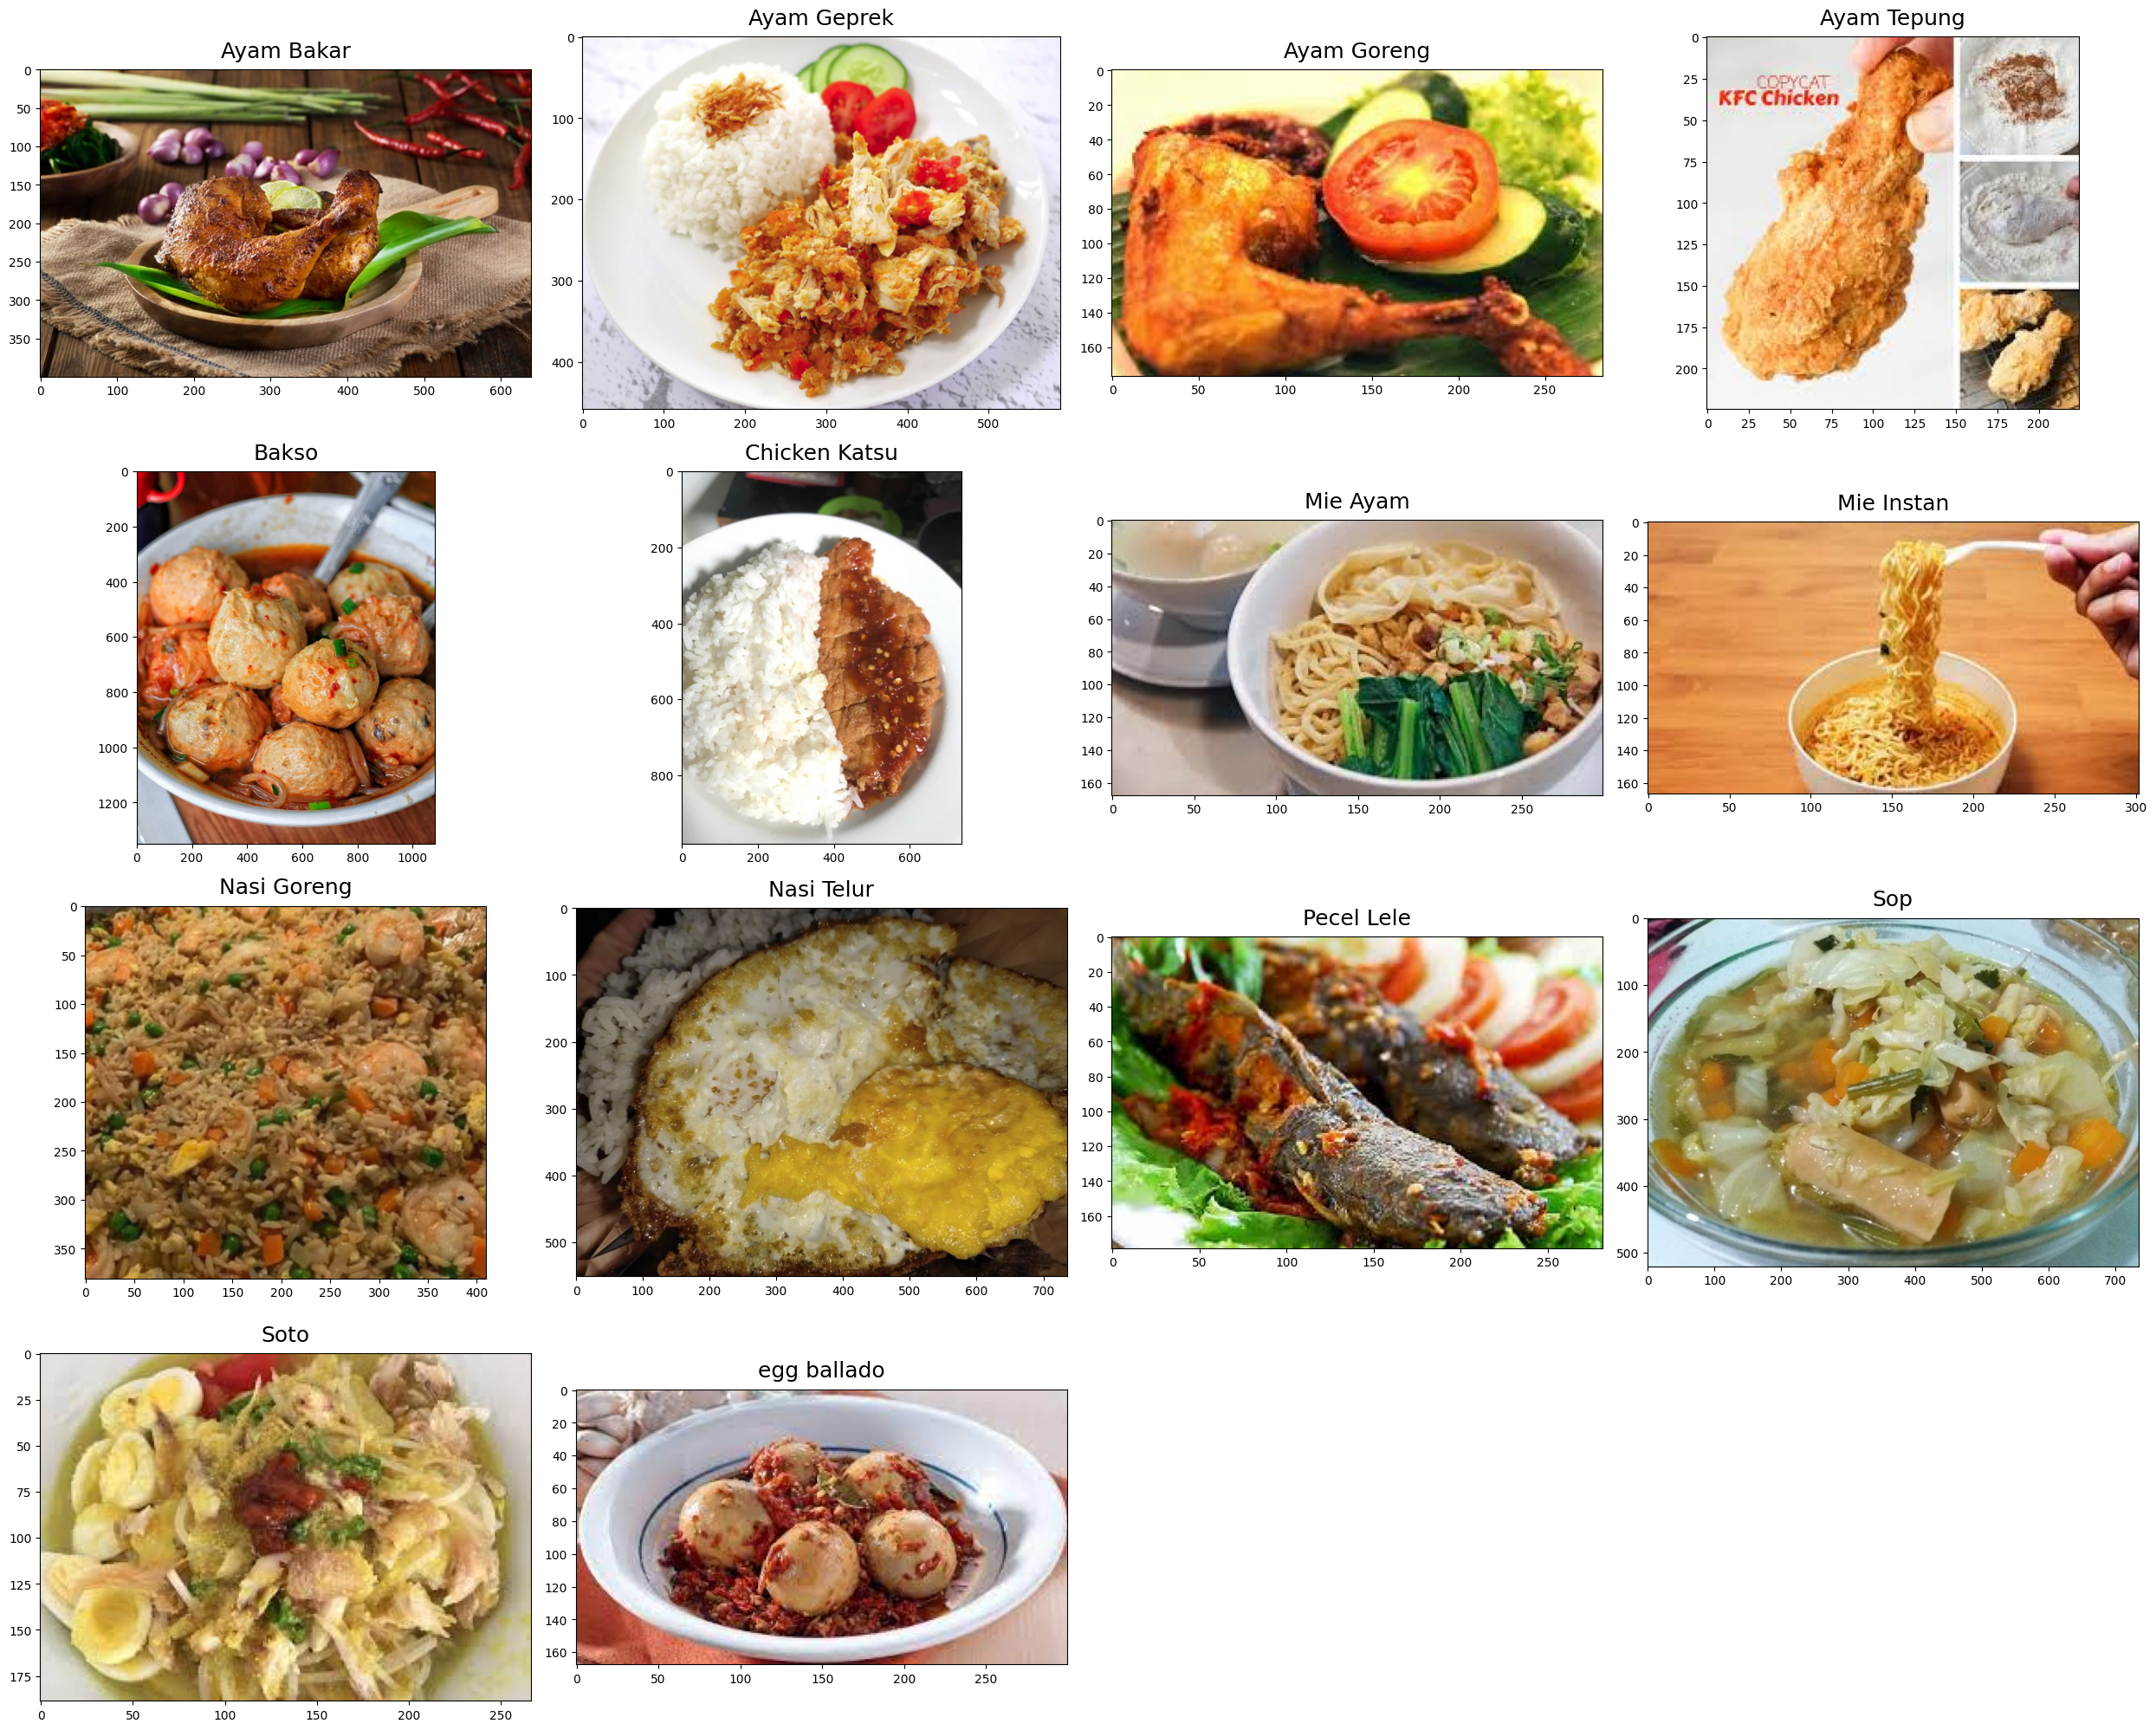

In [4]:
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [5]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 4699 images belonging to 14 classes.
Found 970 images belonging to 14 classes.


Making Callbacks for Training

In [6]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
)

In [7]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

for layer in resnet.layers:
    layer.trainable = False

Making Model

In [8]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(14,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 14)                910       
                                                                 
Total params: 24647630 (94.02 MB)
Trainable params: 1082830 (4.13 MB)
Non-trainable params: 23564800 (89.89 MB)
__________

In [9]:
# model.load_weights('Weights/weight')
model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_generator,epochs=5,validation_data=test_generator,callbacks=[model_checkpoint_callback])


Epoch 1/5


470/470 [==============================] - 822s 2s/step - loss: 1.1753 - accuracy: 0.6189 - val_loss: 1.0786 - val_accuracy: 0.6495
Epoch 2/5
470/470 [==============================] - 761s 2s/step - loss: 0.7789 - accuracy: 0.7459 - val_loss: 0.8816 - val_accuracy: 0.7093
Epoch 3/5
123/470 [======>.......................] - ETA: 7:42 - loss: 0.6474 - accuracy: 0.7951

KeyboardInterrupt: 

In [ ]:
model.save_weights('Weights/weight')

RESULTS

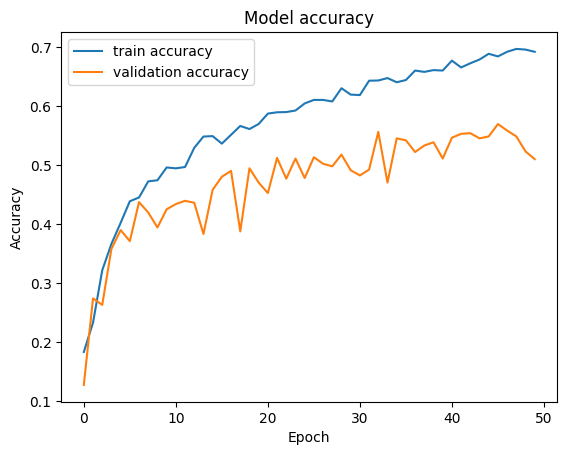

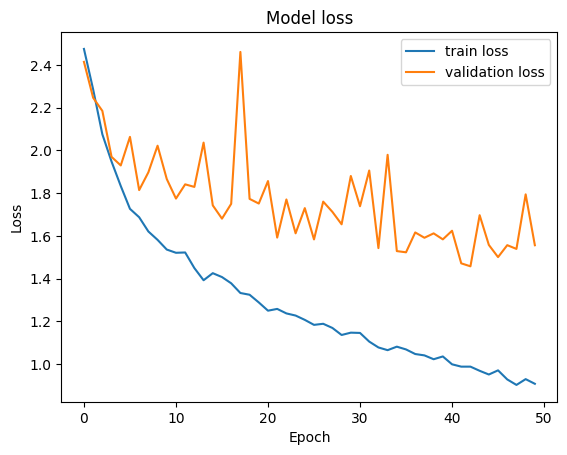

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [ ]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

454/454 [==============================] - 9s 20ms/step


CONFUSION MATRIX

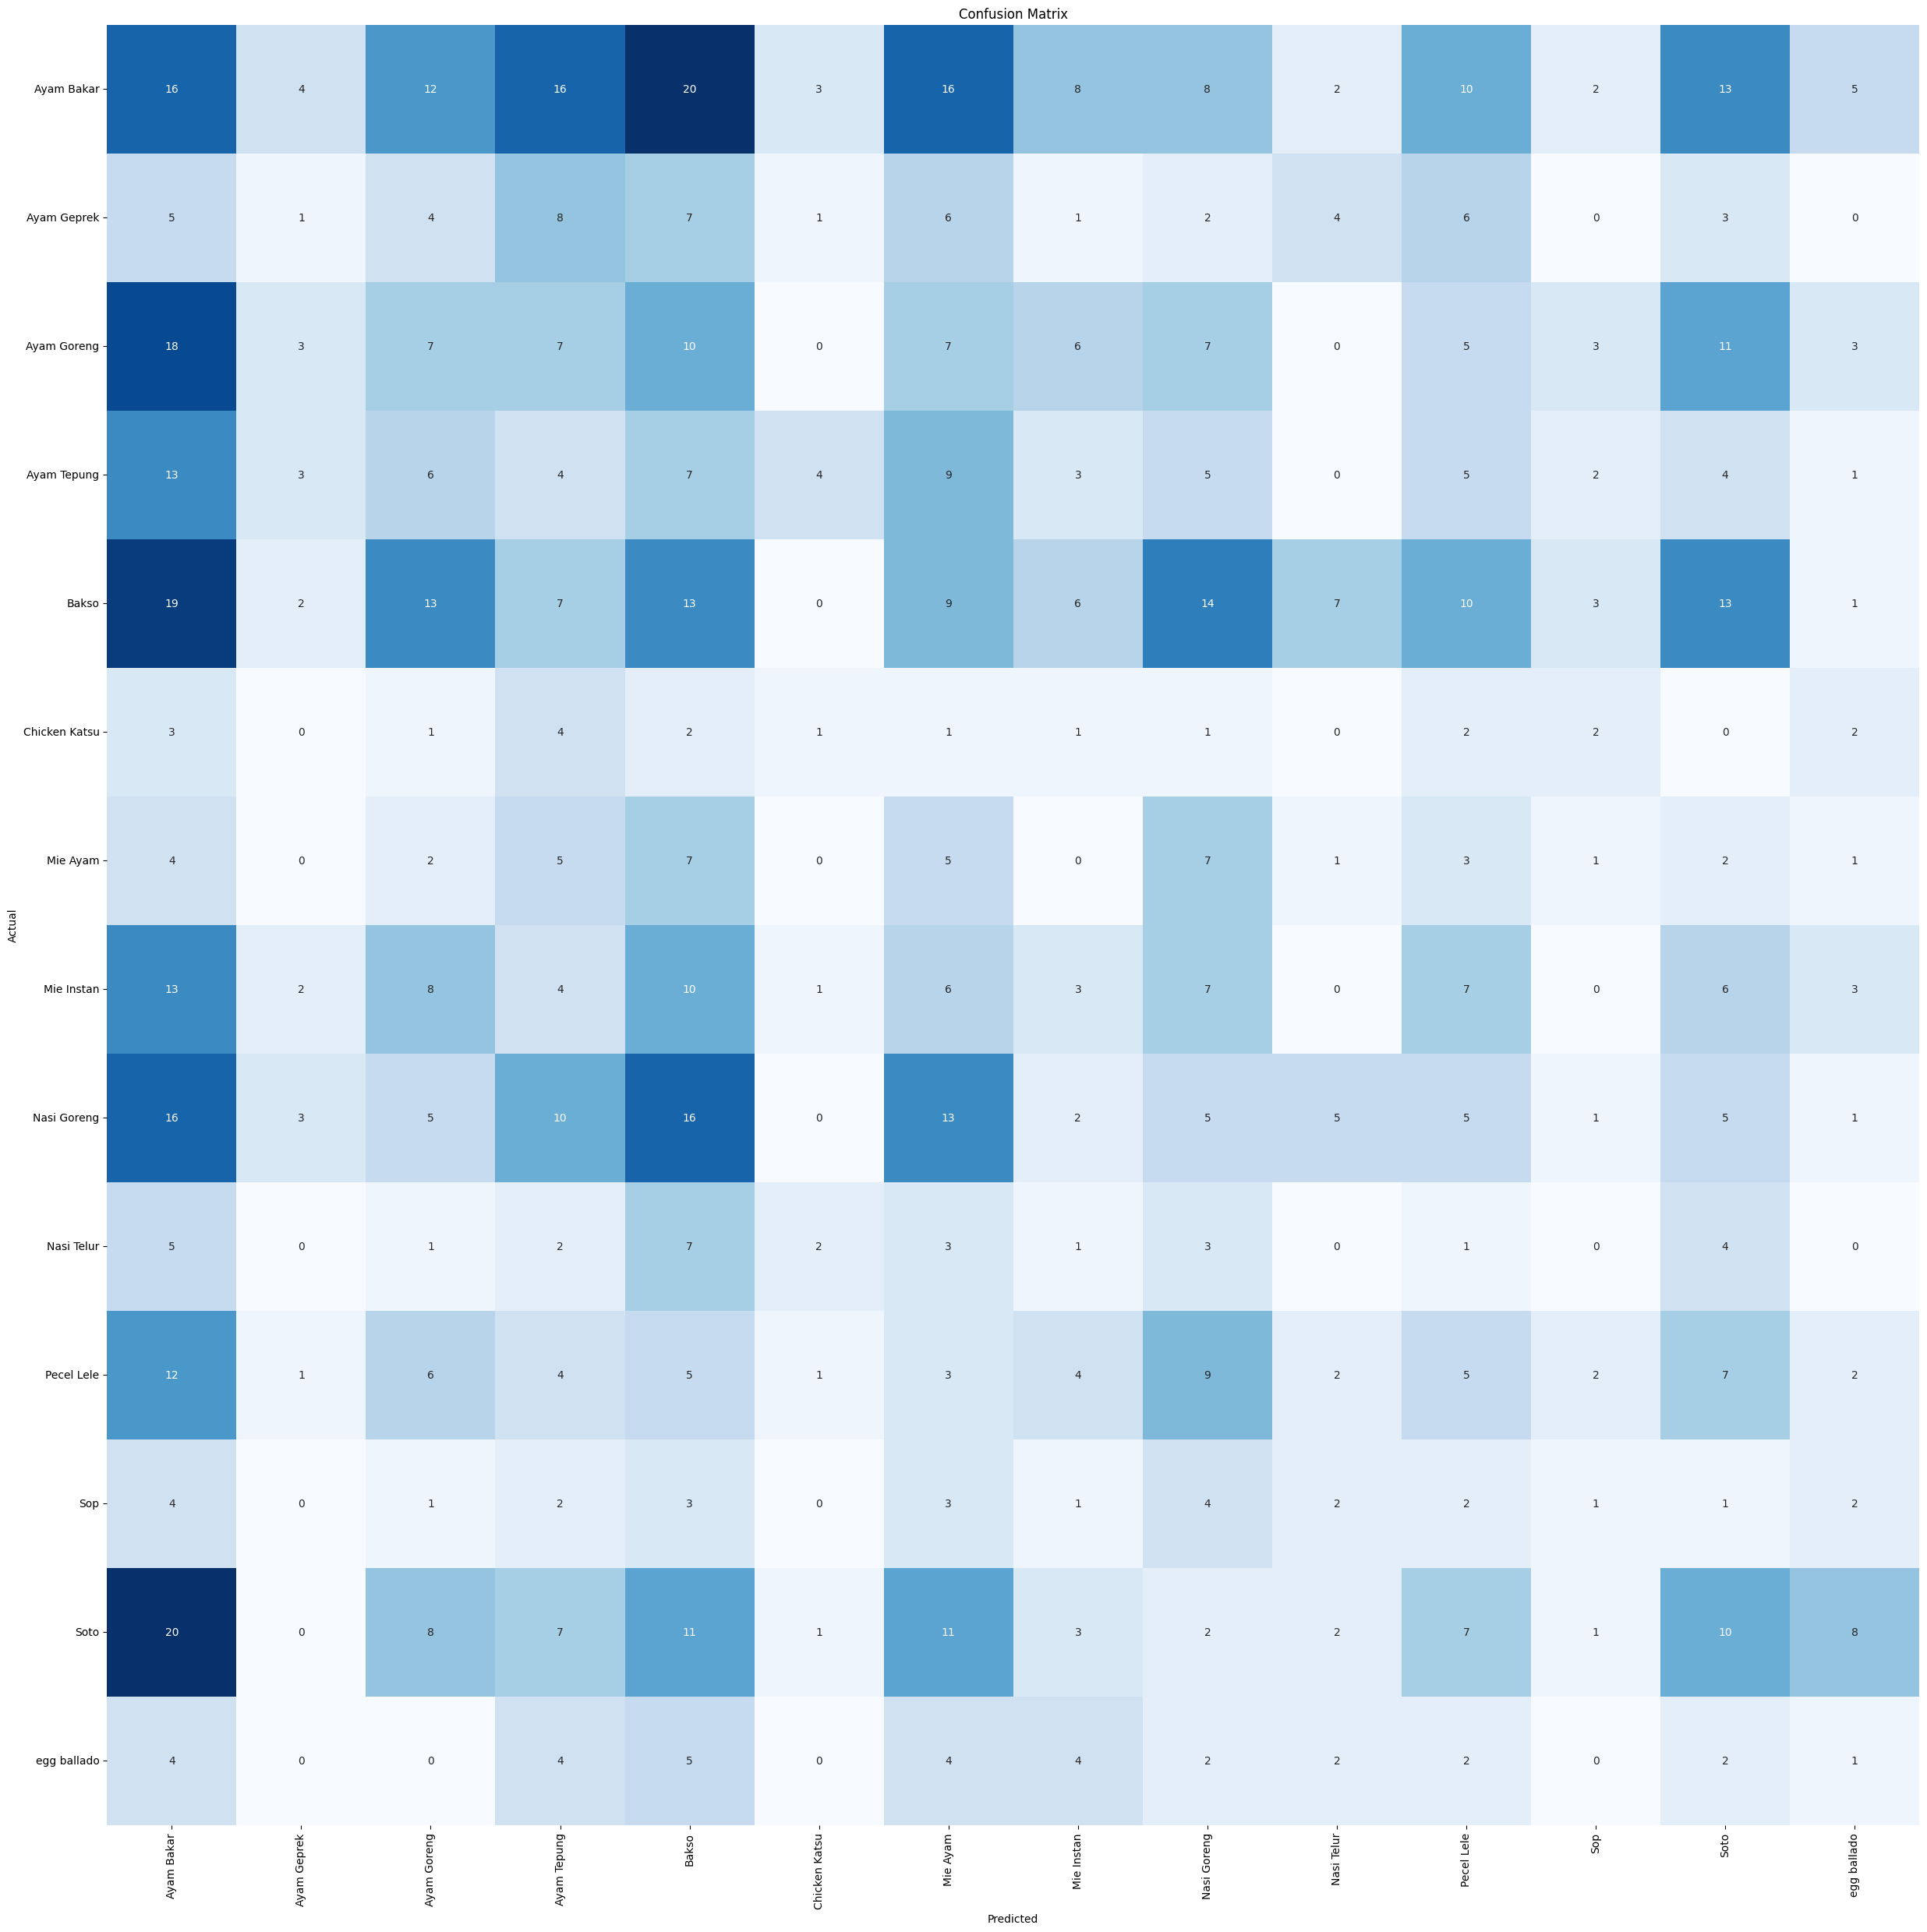

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.11      0.12      0.11       135
  Ayam Geprek       0.05      0.02      0.03        48
  Ayam Goreng       0.09      0.08      0.09        87
  Ayam Tepung       0.05      0.06      0.05        66
        Bakso       0.11      0.11      0.11       117
Chicken Katsu       0.07      0.05      0.06        20
     Mie Ayam       0.05      0.13      0.07        38
   Mie Instan       0.07      0.04      0.05        70
  Nasi Goreng       0.07      0.06      0.06        87
   Nasi Telur       0.00      0.00      0.00        29
   Pecel Lele       0.07      0.08      0.08        63
          Sop       0.06      0.04      0.05        26
         Soto       0.12      0.11      0.12        91
  egg ballado       0.03      0.03      0.03        30

     accuracy                           0.08       907
    macro avg       0.07      0.07      0.06       907
 weighted avg   

VISUALIZING WHAT CONVOLUTIONAL LAYER HAS DONE TO OUR DATASET

In [ ]:
layer_names = [layer.name for layer in model.layers[1:10]]  # Names of layers for plotting
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # Number of features in the feature map
    size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features)
    n_cols = n_features // 8  # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, 8 * size))
    for col in range(n_cols):  # Tiles each filter into a big horizontal grid
        for row in range(8):
            channel_image = layer_activation[0, :, :, col * 8 + row]
            channel_image -= channel_image.mean()  # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()